# Sehgal Radio Sources

Implementing new models like radio sources in the `xgpaint.jl` framework is trivial (I hope). Actually, it'll be really interesting to see what parts of are shared between CIB and radio. This will inform the architecture of the final code package.

# 1. Read a Catalog

We operate with HDF5. I convert the `.pksc` format into `.hdf5` in the `pksc2hdf5.py` script (needs some work).

In [1]:
using PyPlot
PyPlot.svg(true);

In [2]:
const NPROCS = 40

using Distributed
addprocs(NPROCS);

In [3]:
@everywhere begin
    using HDF5
    using SharedArrays
    using Healpix
    using PoissonRandom
    using Distributions
    using Interpolations
    using QuadGK
    using Base.GC
    using Roots
    using Cosmology
    using Unitful
    using UnitfulAstro
    
    using Random
    # set different seeds for worker IDs
    Random.seed!(myid() + trunc(Int64, time()))
end

The radio sources do not have "centrals" or "satellites". They just live in the halos. Hence, we are storing instead `halo_n_I` and `halo_n_II`, the halo occupation numbers.

In [4]:
@time begin
    hdata = h5open("/tigress/zequnl/xgpaint/websky_halos-light.hdf5", "r") do file
        read(file, "halos")
    end
    
    N_halos = size(hdata,2)
    
    halo_x_pos = SharedArray{Float32}(N_halos)
    halo_y_pos = SharedArray{Float32}(N_halos)
    halo_z_pos = SharedArray{Float32}(N_halos)
    halo_mass = SharedArray{Float32}(N_halos)
    
    # fill up known quantities
    halo_x_pos .= hdata[1,:]
    halo_y_pos .= hdata[2,:]
    halo_z_pos .= hdata[3,:]
    halo_mass .= hdata[4,:]
    hdata = 0
    @everywhere GC.gc()
    
    # derived parameters
    halo_comoving_dist = SharedArray{Float32}(N_halos)
    halo_redshift = SharedArray{Float32}(N_halos)
    
    halo_n_I = SharedArray{Int32}(N_halos)
    halo_n_II = SharedArray{Int32}(N_halos)
end;

 53.697582 seconds (6.27 M allocations: 26.020 GiB, 1.17% gc time)


We specify the parameters here. We're taking the model parameters straight from Table 2 of Sehgal et al. 2009.

![pasted image](data/table.png)

In [5]:
@everywhere begin
    # sehgal model parameters
    
    # these coefficients are shared for type I and II
    const a_0   = 0.0
    const a_1_dist = Uniform(-0.12,  0.07)
    const a_2_dist = Uniform(-0.34,  0.99)
    const a_3_dist = Uniform(-0.75, -0.23)
    
    const I_R_int = 10^(-2.6)
    const I_γ = 6.0
    const I_N_0 = 1.0
    const I_M_0 = 4e13
    const I_α = 0.1
    const I_L_b = 10^(24.0)
    const I_m = -1.55
    const I_n = 0.0
    const I_δ = 3.0
    const I_z_p = 0.8
    
    const II_R_int = 10^(-2.8)
    const II_γ = 8.0
    const II_N_0 = 0.015
    const II_M_0 = 3e15
    const II_α = 0.1
    const II_L_b = 10^(27.5)
    const II_m = -1.6
    const II_n = -0.65
    const II_z_p = 1.3
    const II_σ_l = 0.4
    const II_σ_h = 0.73
    
    
    # output
    const nside   = 4096
    
    # physical constants
    const phys_h     = 6.62606957e-27   # erg.s
    const phys_c     = 3e+10            # cm/s
    const phys_k     = 1.3806488e-16    # erg/K
    const phys_Msun  = 2e33             # g
    const phys_Mpc   = 3.086e24         # cm
    
    # cosmology
    const omegab  = 0.043
    const omegac  = 0.207
    const omegam  = omegab + omegac
    const h = 0.7
    const rhocrit = 2.78e11 * omegam * (h^2)
    
    const jl_cosmo = cosmology(h=h, OmegaM=omegam)
end

In [6]:
@everywhere function build_r2z_interpolator()
    """
    Construct a fast r2z linear interpolator.
    """
    zrange = LinRange(0.0, 6.0, 1000)
    rrange = [ustrip(comoving_radial_dist(u"Mpc", jl_cosmo, z))
        for z in zrange];
    r2z = LinearInterpolation(rrange, zrange);
    return r2z
end

@everywhere const r2z = build_r2z_interpolator()

In [7]:
function fill_halovars!(
        x, y, z, # inputs
        redshift_result, dist_result) # outputs
    """
    This function computes distance and redshift in parallel.
    """
    
    N_halos = size(x,1)
    @sync @distributed for i = 1:N_halos
        dist_result[i] = sqrt(x[i]^2 + y[i]^2 + z[i]^2)
        redshift_result[i] = r2z(dist_result[i])
    end
end

fill_halovars! (generic function with 1 method)

We compute the comoving distance, spherical coordinates, and redshift of the halos and store them in the shared memory array `halo_derived`. It's in parallel, so it takes just seconds!

In [8]:
@time fill_halovars!(halo_x_pos, halo_y_pos, halo_z_pos,
    halo_redshift, halo_comoving_dist)

  3.414612 seconds (2.00 M allocations: 103.035 MiB, 0.82% gc time)


Task (done) @0x00002af304a1ebf0

In [9]:
@everywhere GC.gc()

# 2. HOD
We assign a number of satellites to each halo. Sehgal assumes the halo occupation number (HON) is given by
$$ N(M) = N_0 (M / M_0)^{\alpha}.$$

In [10]:
@everywhere begin
    pdf_norm1(x, μ, σ) = exp( -(x-μ)^2 / (2 * σ^2) );

    function FR_I_redshift_evolution(z)
        if z < I_z_p
            return (1+z)^I_δ
        else
            return (1+I_z_p)^I_δ
        end
    end

    function FR_II_redshift_evolution(z)
        norm = pdf_norm1(0, II_z_p, II_σ_l)
        if z < II_z_p
            return pdf_norm1(z, II_z_p, II_σ_l) / norm
        else
            return pdf_norm1(z, II_z_p, II_σ_h) / norm
        end
    end
end

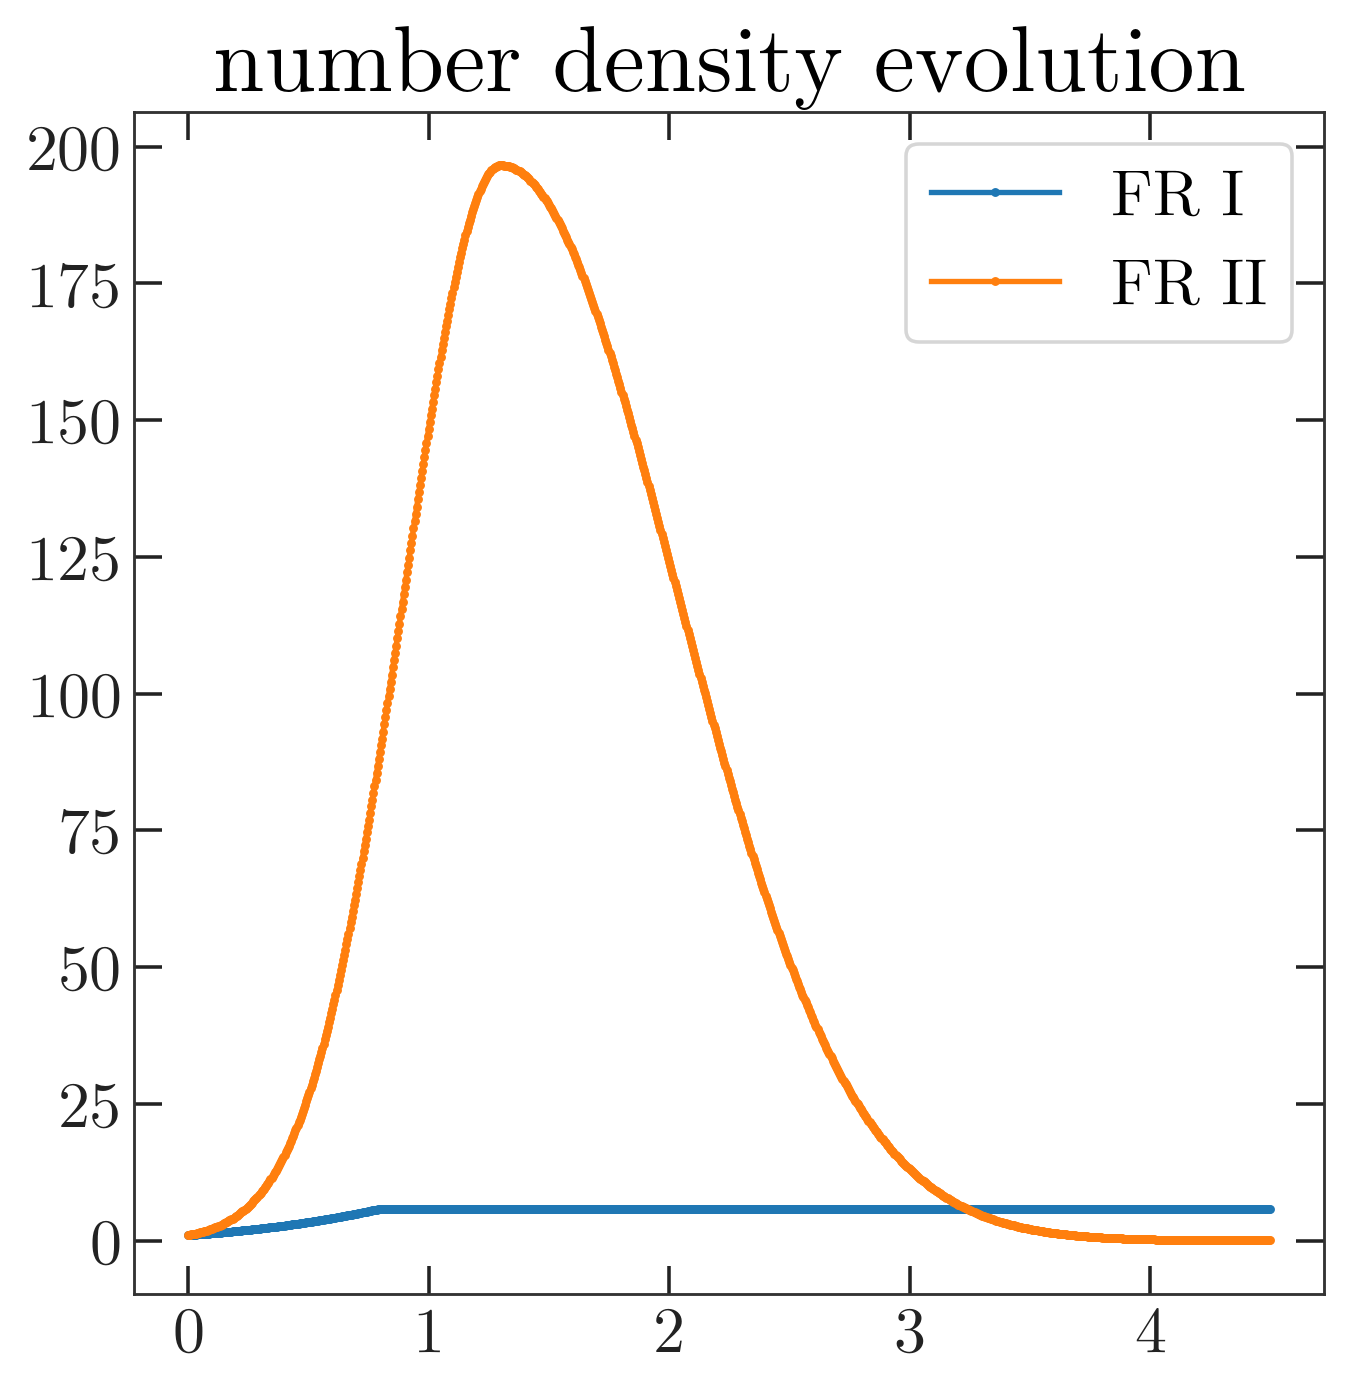

PyObject <matplotlib.legend.Legend object at 0x2af34ea02b38>

In [11]:
zt = LinRange(0.0, 4.5, 1000)

plot(zt, FR_I_redshift_evolution.(zt), label="FR I")
plot(zt, FR_II_redshift_evolution.(zt), label="FR II")

title("number density evolution")
legend()

In [12]:
function hod_sehgal(n_I_result, n_II_result,
        halo_mass::SharedArray, z::SharedArray)
    # computes sehgal HOD and generates a Poisson draw
    N_halos = size(halo_mass,1)
    
    @sync @distributed for i = 1:N_halos
        I_HON = I_N_0 * (halo_mass[i] / I_M_0)^I_α 
        I_HON *= FR_I_redshift_evolution(z[i])
        n_I_result[i] = pois_rand(convert(Float64, I_HON))
        
        II_HON = II_N_0 * (halo_mass[i] / II_M_0)^II_α
        II_HON *= FR_II_redshift_evolution(z[i])
        n_II_result[i] = pois_rand(convert(Float64, II_HON))
    end
    
end

hod_sehgal (generic function with 1 method)

In [13]:
@time hod_sehgal(halo_n_I, halo_n_II, halo_mass, halo_redshift)

  6.595013 seconds (482.22 k allocations: 24.968 MiB, 0.11% gc time)


Task (done) @0x00002af302c11d50

# 3. Halos to Sources to Maps

This is a loop *for each halo*, which does the following.

```
for loop over $n_{halo}$
    for loop over $n_{sat}$ of the halo
        do tasks
```

### Tasks
1. draw a random source
2. assign it a luminosity 
3. convert that luminosity to a flux
4. map to a healpix pixel index and add that flux

The Sehgal LF is

$$ p(L) = \begin{cases}   (L/L_b)^m &  L > L_b \\  (L/L_b)^n & \mathrm{otherwise} \end{cases} $$

In [14]:
@everywhere begin
    function sehgal_LF(m, n, Lb)
        norm = Lb/(1+n) - Lb/(1+m)
        x = norm * rand()
        if x < (Lb / (1+n) )
            return Lb * (((1 + n) * x)/Lb)^(1/(1 + n))
        else
            return Lb * (-(((1 + m) * (-(Lb/(1 + m)) + Lb/(1 + n) - x))/Lb))^(1/(1 + m))
        end
    end
end

## Lobe/Core and Spectral Shape

We draw a luminosity $L_{beam}$ from $p(L)$ described above. Then we can divide this into two separate components, 

$$ L_{\mathrm{beam}} = L_{c,\mathrm{beam}} + L_{l,\mathrm{int}} . $$

The core-to-lobe flux ratio $R_{\mathrm{obs}} \equiv L_{c,\mathrm{beam}}/L_{l,\mathrm{int}}$ is also randomly generated. We assume a uniform distribution of $\cos \theta$, the angle between the line-of-sight and the jet axis. The inputs here are

1. our random $L_{\mathrm{beam}}$ draw from $p(L)$
2. fixed $R_{\mathrm{int}}$ and $\gamma$ from Wilman et al. 2008 [W08] 
3. a random draw of $\cos \theta \in [0,1]$.

We can then calculate the ratio

$$ R_{\mathrm{obs}} = R_{\mathrm{int}} B(\theta) \quad \quad \beta = \sqrt{1-\gamma^{-2}} $$
$$ B(\theta) = [ (1-\beta \cos \theta)^{-2} + (1 + \beta \cos \theta)^{-2} ] / 2.$$

Now you have the observed ratios, you can write 

$$ L_{c,\mathrm{beam}} = \frac{ R_{\mathrm{obs}} L_{\mathrm{beam}} }{ 1 + R_{\mathrm{obs}} }, \quad \quad L_{l,\mathrm{int}} = \frac{ L_{\mathrm{beam}} }{1 + R_{\mathrm{obs}}}.$$

Each component has its own spectral shape. For $a_i$ drawn from uniform distributions (see table) for each source,

$$ \log f_{\mathrm{core}}(\nu) = \sum_{i=0}^3 a_i \left(\log \frac{\nu}{151 \, \mathrm{MHz}} \right)^i , $$
$$ f_{\mathrm{lobe}}(\nu) = \left( \frac{\nu}{151 \, \mathrm{MHz}} \right)^{-0.8}.$$

We normalize both spectral shapes such that $ f(151 \, \mathrm{MHz}) = 1$ because I'm assuming $p(L)$ is describing the $z \sim 0$, 151 MHz RLF.

In [15]:
@everywhere begin
    B(cosθ, β) = ( (1-β*cosθ)^(-2) + (1+β*cosθ)^(-2) ) / 2.0

    function get_core_lobe_lum(L, ν_Hz, R_int, γ)
        β = sqrt(1-γ^(-2))
        cosθ = rand()
        R_obs = R_int * B(cosθ, β)

        # compute how the luminosity is split up
        L_c = R_obs * L / (1 + R_obs)
        L_l = L / (1 + R_obs)

        # now put in the frequency dependence. a_0 = 0.0
        a_1 = rand(a_1_dist)
        a_2 = rand(a_2_dist)
        a_3 = rand(a_3_dist)
        lν = log10(ν_Hz / 151e6 ) # normed to GHz
        f_core =  10 .^ ( a_1*lν + a_2*lν^2 + a_3*lν^3 )
        f_lobe = (ν_Hz / 151e6 )^(-0.8)

        return L_c * f_core, L_l * f_lobe
    end
end

In [23]:
@everywhere function l2f(Lum, r_comoving, redshift)
    return Lum / (4π * r_comoving^2 * (1.0 + redshift))
end

In [24]:
@everywhere const Healpix_res = Resolution(nside)

In [25]:
function make_map(x, y, z, d_cm, redshift, 
        n_I, n_II, ν_obs,
        
        debug_mode=false, I_ind=nothing, II_ind=nothing,
        L_I=nothing, L_II=nothing, z_I=nothing, z_II=nothing
    )
    """Generate a CIB map given a HOD.
    
    Frequency ν_obs must be in Hz.
    """
    N_halos = size(d_cm,1)

    result_map = SharedArray{Float64}(Healpix.nside2npix(nside)); 
    result_map .= 0.0 # initialize to zero
    
    @sync @distributed  for i = 1:N_halos
        
        # all sources are smack on the halo
        ν_Hz = (1+redshift[i]) * ν_obs
        hp_index = Healpix.vec2pixRing(Healpix_res, x[i], y[i], z[i])
        
        # do it for FR_I
        for j = 1:n_I[i]
            L = sehgal_LF(I_m, I_n, I_L_b)
            L_c, L_l = get_core_lobe_lum(L, ν_Hz, I_R_int, I_γ)
            flux = l2f(L_c + L_l, d_cm[i], redshift[i])
            result_map[hp_index] += flux
                        
            if debug_mode
                L_I[I_ind[i] + j] = L_c + L_l
                z_I[I_ind[i] + j] = redshift[i]
            end
        end
        
        # do it for FR_II
        for j = 1:n_II[i]
            L = sehgal_LF(II_m, II_n, II_L_b)
            L_c, L_l = get_core_lobe_lum(L, ν_Hz, II_R_int, II_γ)
            flux = l2f(L_c + L_l, d_cm[i], redshift[i])
            result_map[hp_index] += flux
            
            if debug_mode
                L_II[II_ind[i] + j] = L_c + L_l
                z_II[II_ind[i] + j] = redshift[i]
            end
        end
        
    end
    
    meters_per_mpc = 3.086e+22
    pix_area = Healpix.nside2pixarea(nside) / meters_per_mpc^2
    return result_map ./ pix_area 
end

make_map (generic function with 8 methods)

In [26]:
# @time begin
#     halo_I_ind = SharedArray{Int64}(N_halos)
#     halo_II_ind = SharedArray{Int64}(N_halos)
    
#     function gen_ind(I_ind, II_ind)
#         cI = 0
#         cII = 0
#         for i in 1:N_halos
#             I_ind[i] = cI
#             cI += halo_n_I[i]
#             II_ind[i] = cII
#             cII += halo_n_II[i]
#         end
#     end
    
#     gen_ind(halo_I_ind, halo_II_ind)
# end

# @time result = make_map(
#     halo_x_pos, halo_y_pos, halo_z_pos, 
#     halo_comoving_dist, halo_redshift,
#     halo_n_I, halo_n_II, 100e9,
    
#     true, halo_I_ind, halo_II_ind, halo_L_I, halo_L_II, halo_z_I, halo_z_II
# );

In [27]:
@time result = make_map(
    halo_x_pos, halo_y_pos, halo_z_pos, 
    halo_comoving_dist, halo_redshift,
    halo_n_I, halo_n_II, 151e6
);

 55.253952 seconds (339.73 k allocations: 1.518 GiB, 0.18% gc time)


In [26]:
# using Plots
# gr()  # Use the GR backend

# logm = Map{Float64, RingOrder}(nside)
# logm.pixels .= log10.(result);
# Plots.plot( logm )

In [28]:
run(`rm /tigress/zequnl/xgpaint/radio100.fits`)

Process(`rm /tigress/zequnl/xgpaint/radio100.fits`, ProcessExited(0))

In [29]:
m = Map{Float64, RingOrder}(nside)
m.pixels .= result;
Healpix.saveToFITS(m, "/tigress/zequnl/xgpaint/radio100.fits")